In [4]:
import numpy as np
import torch
import dgl
from torch import nn


def get_complete_edges(g):
    def leading_zero(x):
        yield torch.zeros_like(x[0])
        yield from x
    x = torch.cumsum(g.batch_num_nodes(), 0)
    all_edges = []
    for a, b in zip(leading_zero(x), x):
        edges = torch.combinations(torch.arange(a, b))
        all_edges.append(edges)
    return torch.cat(all_edges, 0).T

def add_complete_edges(g):
    n1 = g.number_of_nodes()
    edges = get_complete_edges(g)
    g.add_edges(edges[0], edges[1])
    g.add_edges(edges[1], edges[0])
    n2 = g.number_of_nodes()
    assert n1 == n2
    return g

Using backend: pytorch


# Train on Lung Cancer

## Load Data

In [5]:
import pandas as pd

df = pd.read_csv('lucas0_train.csv')
df.head()

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1


### Loader and Transforms

In [103]:
import typing

class Compose(typing.Callable):
    
    def __init__(self, *transforms):
        self.transforms = transforms
        
    def __call__(self, x):
        for transform in self.transforms:
            x = transform(x)
        return x

class ToDGLFullyConnected(typing.Callable):
    
    def __init__(self, keys, feature_key='feat', target_key='targ'):
        self.keys = keys
        self.key_to_idx = {k: i for i, k in enumerate(keys)}
        self.feature_key = feature_key
        self.target_key = target_key
        
    @staticmethod
    def leading_zero(x):
        yield torch.zeros_like(x[0])
        yield from x
        
    @classmethod
    def get_complete_edges(cls, g):
        x = torch.cumsum(g.batch_num_nodes(), 0)
        all_edges = []
        for a, b in zip(cls.leading_zero(x), x):
            edges = torch.combinations(torch.arange(a, b))
            all_edges.append(edges)
        return torch.cat(all_edges, 0).T

    @classmethod
    def add_complete_edges(cls, g):
        n1 = g.number_of_nodes()
        edges = cls.get_complete_edges(g)
        g.add_edges(edges[0], edges[1])
        g.add_edges(edges[1], edges[0])
        n2 = g.number_of_nodes()
        assert n1 == n2
        return g
        
    def __call__(self, row):
        g = dgl.graph(([], []))
        g.add_nodes(len(row))
        idx = [self.key_to_idx[k] for k in row.keys()]
        g.ndata[self.feature_key] = torch.tensor(idx).long()
        add_complete_edges(g)
        g.ndata[self.target_key] = torch.tensor(list(row.values())).unsqueeze(1).float()
        return g
    
class CloneNodeData(typing.Callable):
    
    def __init__(self, from_key: str, to_key: str):
        self.from_key = from_key
        self.to_key = to_key
        
    def __call__(self, g):
        g.ndata[self.to_key] = g.ndata[self.from_key].detach().clone()
        return g
        
class MaskNodeData(typing.Callable):
    
    def __init__(self, index: int, key: str, mask_key='m', mask_value=0):
        
        self.index = index
        self.key = key
        self.mask_key = mask_key
        self.mask_value = mask_value
        
        
    def __call__(self, g):
        mask = torch.zeros_like(g.ndata[self.key]).long()
        mask[self.index] = 1
        mask = mask.bool()
        g.ndata[self.mask_key] = mask
        g.ndata[self.key][mask] = self.mask_value
        return g
        
t = Compose(
    ToDGLFullyConnected(list(df.columns), feature_key='x', target_key='y'), 
    CloneNodeData('y', 'y_hat'),
    MaskNodeData(-1, key='y', mask_key='mask', mask_value=-1))
t(row.to_dict())


Graph(num_nodes=12, num_edges=132,
      ndata_schemes={'x': Scheme(shape=(), dtype=torch.int64), 'y': Scheme(shape=(1,), dtype=torch.float32), 'y_hat': Scheme(shape=(1,), dtype=torch.float32), 'mask': Scheme(shape=(1,), dtype=torch.bool)}
      edata_schemes={})

In [115]:
from torch.utils.data import DataLoader, Dataset

class PdDataset(Dataset):
    
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        self.transformed = {}
        
    def __getitem__(self, idx):
        x = df.iloc[idx].to_dict()
        if self.transforms:
            if isinstance(self.transforms, (list, tuple)):
                for t in self.transforms:
                    x = t(x)
            elif callable(self.transforms):
                x = self.transforms(x)
            else:
                raise TypeError("Transforms must be callable or an list or tuple of callables")
        return x
    
    def __len__(self):
        return len(self.df)
    
    def split(self, *splits):
        x = torch.tensor(splits)
        x = torch.cumsum(x, 0) / x.sum()
        
        idx = len(self) * x
        idx = [0] + idx.long().tolist()
        idx[-1] = None
        idx[0] = None
        datasets = []
        for i, j in zip(idx[:-1], idx[1:]):
            datasets.append(self.__class__(self.df.iloc[i:j], transforms=self.transforms))
        return datasets 
        
class CachedDataset(Dataset):
    
    def __init__(self, dataset):
        self.cache = {}
        self.dataset = dataset
        
    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]
        else:
            x = self.dataset[idx]
            self.cache[idx] = x
            return x
        
    def __len__(self):
        return len(self.dataset)
    
    def split(self, *splits):
        return [self.__class__(s) for s in self.dataset.split(*splits)]
        
LeaveOneOut = Compose(
    ToDGLFullyConnected(list(df.columns), feature_key='x', target_key='y'), 
    CloneNodeData('y', 'y_hat'),
    MaskNodeData(-1, key='y', mask_key='mask', mask_value=-1)
)
dataset = PdDataset(df=df, transforms=LeaveOneOut)

In [114]:
from abc import ABC, abstractmethod
from torch import nn
from typing import *
import torch
from copy import deepcopy
import matplotlib as mpl
from matplotlib import cm
from dgl import ops as Fops


def clones(net, N):
    return [deepcopy(net) for _ in range(N)]
    
    
class SizedModule(ABC) :

    @abstractmethod
    def get_size(self) -> int:
        ...
                  
class AddNorm(nn.Module):
    
    def __init__(self, size: Optional[int] = None, dropout: float = 0.1, layer: Optional[SizedModule] = None):
        super().__init__()
        if size is None and layer is None:
            return ValueError("Either size or layer must be provided")
        self.size = size or layer.get_size()
        self.layer = layer
        self.norm = nn.LayerNorm(self.size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, args=None, kwargs=None, layer: Optional[SizedModule] = None):
        kwargs = kwargs or dict()
        if args is None:
            args = (x,)
        layer = layer or self.layer
        return self.norm(x + self.dropout(layer(*args, **kwargs)))
    

    
class MultiHeadAttention(nn.Module):
    
    def __init__(self, dim_model, h):
        super().__init__()
        assert dim_model % h == 0
        self.h = h
        self.dim_model = dim_model
        self.d_k = dim_model // h
        self.linears  = clones(nn.Linear(dim_model, dim_model), 4)
        self.attn = None
    
    def _view_head(self, x):
        return x.view(x.size(0), -1, self.h, self.d_k).transpose(1, 2)
        
    def forward(self, g, query, key, value):
        q = self._view_head(self.linears[0](query))
        k = self._view_head(self.linears[1](key))
        v = self._view_head(self.linears[2](value))
        score = Fops.edge_softmax(g, Fops.v_dot_u(g, q, k) / self.d_k**0.5)
#         score = Fops.v_dot_u(g, q, k) / self.d_k**0.5
#         score = F.leaky_relu(Fops.v_dot_u(g, q, k) / self.d_k**0.5)
        out = Fops.u_mul_e_sum(g, v, score)
        out = out.transpose(1, 2).view(g.number_of_nodes(), self.h * self.d_k)
        score = score.view(score.size(0), self.h, -1)
        self.attn = score
        out = self.linears[3](out)
        return out
    

class Network(nn.Module):
    
    def __init__(self, d_model, h=16, n_heads=4, dropout=0.2):
        super().__init__()
        self.src_embedding = nn.Sequential(
            nn.Embedding(d_model, h),
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU()
        )
        self.dst_embedding = nn.Sequential(
            nn.Embedding(d_model, h),
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU()
        )
        self.encode = nn.Sequential(
            nn.Linear(1, h),
            nn.LeakyReLU(),
        )
        self.attn = AddNorm(h, layer=MultiHeadAttention(h, n_heads), dropout=dropout)
        self.core = nn.Sequential(
            nn.Linear(h, h),
            nn.LeakyReLU(),
        )
        self.decode = nn.Sequential(
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, 1)
        )
            
        
    def forward(self, g, x, y, n_loops=5):
        with g.local_scope():
            g.ndata['a'] = self.src_embedding(x.flatten().long())
            g.ndata['b'] = self.dst_embedding(x.flatten().long())
            g.ndata['h'] = self.encode(y.float())
            out_arr = []
            for i in range(n_loops):

                g.ndata['h'] = self.attn(g.ndata['h'], args=(g, g.ndata['a'], g.ndata['b'], g.ndata['h']))
                g.ndata['h'] = self.core(g.ndata['h'])
                out = nn.Sigmoid()(self.decode(g.ndata['h']))
                out_arr.append(out)
            
            return out_arr
        
net = Network(d_model=len(df.columns)*2, h=128, n_heads=4, dropout=0.2)
g = dataset[0]
net(g, g.ndata['x'], g.ndata['y']);

### Training

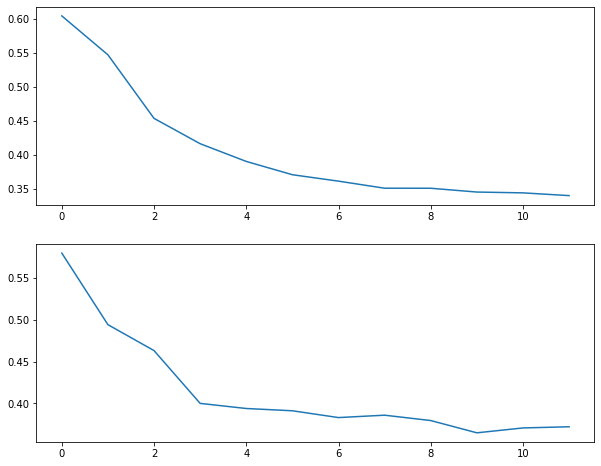

KeyboardInterrupt: 

In [248]:
from tqdm.auto import tqdm
from IPython import display


LeaveOneOut = Compose(
    ToDGLFullyConnected(list(df.columns), feature_key='x', target_key='y'), 
    CloneNodeData('y', 'y_hat'),
    MaskNodeData(-1, key='y', mask_key='mask', mask_value=-1)
)
dataset = PdDataset(df=df, transforms=LeaveOneOut)
dataset = CachedDataset(dataset)
train_dataset, eval_dataset = dataset.split(0.8, 0.2)
datasets = {
    'train': train_dataset,
    'eval': eval_dataset,
    'full': dataset
}

loaders = {
    'train': DataLoader(datasets['train'], batch_size=32, collate_fn=dgl.batch, shuffle=True),
    'eval': DataLoader(datasets['eval'], batch_size=len(datasets['eval']), collate_fn=dgl.batch)
}

net = Network(d_model=len(df.columns)*2, h=32, n_heads=4, dropout=0.2)
optim = torch.optim.AdamW(net.parameters(), lr=1e-3)
lossfn = torch.nn.BCELoss()


def compute_loss(net, g):
    m = g.ndata['mask']
    y_arr = net(g, g.ndata['x'], g.ndata['y'])
    y_hat = g.ndata['y_hat']
    losses = []
    for y in y_arr:
        losses.append(lossfn(y[m], y_hat[m]))
    loss = torch.stack(losses)
    return loss.mean()

def compute_train_loss(net, g):
    net.train()
    return compute_loss(net, g)

def compute_eval_loss(net, g):
    net.eval()
    with torch.no_grad():
        return compute_loss(net, g)

n_epochs = 100
train_losses = []
eval_losses = []
for epoch in tqdm(range(n_epochs)):
    
    # train
    epoch_train_loss = []
    for g in loaders['train']:
        train_loss = compute_train_loss(net, g)
        optim.zero_grad()
        train_loss.backward()
        optim.step()
        epoch_train_loss.append(train_loss.detach().item())
    epoch_train_loss = torch.tensor(epoch_train_loss)
    train_losses.append((epoch, epoch_train_loss.mean()))
        
    # evaluate
    if epoch % 1 == 0:
        epoch_eval_loss = []
        for g in loaders['eval']:
            eval_loss = compute_eval_loss(net, g)
            epoch_eval_loss.append(eval_loss.detach().item())
        epoch_eval_loss = torch.tensor(epoch_eval_loss)
        eval_losses.append((epoch, epoch_eval_loss.mean()))
        
    # plot
    display.clear_output(wait=True)
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    epoch, loss = zip(*train_losses)
    axes[0].plot(epoch, loss)
    
    epoch, loss = zip(*eval_losses)
    axes[1].plot(epoch, loss)
    plt.show()
        
        

#### Evaluation

Classification error: 0.1899999976158142
Sensitivity (true pos): 0.8536585569381714
Specificity (true neg): 0.6991150379180908
Percentage correct: 0.8450000286102295


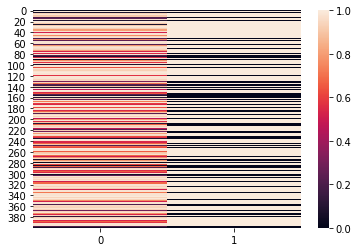

In [249]:
false_pos = (y>=0.5)[~y_hat.bool()].sum() / (~y_hat.bool()).sum()
true_pos = (y>=0.5)[y_hat.bool()].sum() / (y_hat.bool()).sum()
false_neg = (y<0.5)[y_hat.bool()].sum() / (y_hat.bool()).sum()
true_neg = (y<0.5)[~y_hat.bool()].sum() / (~y_hat.bool()).sum()
error = (torch.logical_xor(y >= 0.5, y_hat.bool())).sum() / len(y)
print("Classification error: {}".format(error))
print("Sensitivity (true pos): {}".format(true_pos))
print("Specificity (true neg): {}".format(true_neg))

with torch.no_grad():
    net.eval()
    for g in loaders['eval']:
        ...
    m = g.ndata['mask']
    y = net(g, g.ndata['x'], g.ndata['y'])[-1][m]
    y_hat = g.ndata['y_hat'][m]
perc = (~torch.logical_xor(y_hat.bool(), y > 0.5)).sum() / len(y_hat)
print("Percentage correct: {}".format(perc.item()))
sns.heatmap(torch.stack([y, y_hat]).detach().numpy().T)
plt.show()

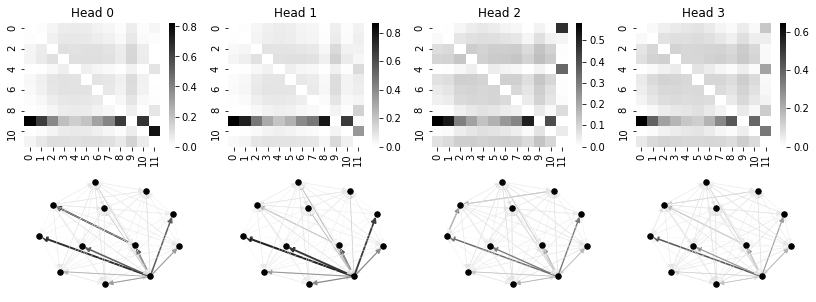

In [250]:
import seaborn as sns
import networkx as nx


def to_nxg(g: dgl.DGLGraph) -> nx.DiGraph:
    nxg = nx.DiGraph(g.to_networkx())
    return nxg
    
def plot_graph(g: dgl.DGLGraph, ax=None, prog='neato', **kwargs):
    nxg = to_nxg(g)
    pos = nx.nx_agraph.pygraphviz_layout(nxg, prog=prog)
    nx.draw(nxg, pos=pos, ax=ax, **kwargs)
    return ax, pos, nxg

def attn_to_sparse(g: dgl.DGLGraph, attn: torch.Tensor):
    n = g.number_of_nodes()
    i = torch.stack(g.edges())
    v = attn
    x = torch.sparse_coo_tensor(i, v.flatten(), (n, n))
    return x


def plot_multihead_attention(g, attn, cmap='binary', node_color='k', node_size=30, prog='neato', scale_width=2., min_width=0.3):
    fig, axes = plt.subplots(2, 4, figsize=(14, 5))
    attn_arr =[]
    for i in range(attn.size(1)):
        ax = axes.flatten()[i]
        ax.set_title("Head {}".format(i))
        a = attn[:, i].detach().flatten()
        _attn = attn_to_sparse(g, a).to_dense().numpy()
        attn_arr.append(_attn)
        sns.heatmap(_attn, ax=ax, linewidths=0, cmap=cmap)
        norm = mpl.colors.Normalize(vmin=0,vmax=1.)
        edge_colors = cm.get_cmap(cmap)(norm(a))
        edges = g.edges()
        edgelist = [(edges[0][i].item(), edges[1][i].item()) for i in range(g.number_of_edges())]
        
        ax, pos, nxg = plot_graph(g, prog=prog, width=a*scale_width + min_width, edge_color=edge_colors, edgelist=edgelist, ax=axes.flatten()[i+4], node_size=node_size, node_color=node_color)

def eval_network():
    g = loaders['eval'].dataset[2]
    net(g, g.ndata['x'], g.ndata['y'])
    attn = net.attn.layer.attn
    plot_multihead_attention(g, attn)
    
eval_network()

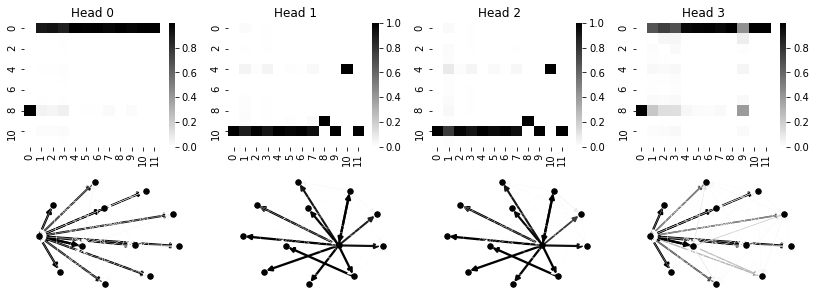

In [160]:
g = loaders['eval'].dataset[-1]
net(g, g.ndata['x'], g.ndata['y'])
attn = net.attn.layer.attn
plot_multihead_attention(g, attn)

In [102]:
from tqdm.auto import tqdm
from IPython import display
from matplotlib import pylab as plt

net = Network(d_model=len(df.columns)*2, h=128, n_heads=4, dropout=0.2)

dataset = LungCancerDataset(df.iloc[:-1000] + df.iloc[:-1000])
loader = DataLoader(dataset, batch_size=256, collate_fn=dgl.batch, shuffle=True)

eval_dataset = LungCancerDataset(df.iloc[-1000:])
eval_loader = DataLoader(dataset, batch_size=len(eval_dataset), collate_fn=dgl.batch, shuffle=False)

optim = torch.optim.AdamW(net.parameters(), lr=1e-3)
lossfn = torch.nn.BCELoss()
losses = []

def evaluate():
    total_loss = 0
    for g in eval_loader:
        net.eval()
        with torch.no_grad():
            m = g.ndata['mask'].bool()
            y_arr = net(g)[-1:]
            
            y_hat = g.ndata['y_hat'][m].float()
            loss = torch.tensor(0.)
            for y in y_arr:
                loss += lossfn(y[m], y_hat.float())
            
            total_loss+=loss.detach().item()
    return total_loss

eval_losses = []
for epoch in tqdm(range(1000)):
    for g in loader:
        m = g.ndata['mask'].bool()
        y_arr = net(g)[-1:]
        y_hat = g.ndata['y_hat'][m].float()
        loss = torch.tensor(0.)
        for y in y_arr:
            loss += lossfn(y[m], y_hat.float())
        print(y_arr[-1][m])
        print(y_hat)
        break
        optim.zero_grad()
        loss.backward()
        optim.step()

#         losses.append(loss.detach().item())
#         display.clear_output(wait=True)
#         plt.plot(losses)
#         plt.show()
        
        display.clear_output(wait=True)
        plt.plot(eval_losses)
        plt.show()
        
    if epoch % 1 == 0:
        eval_loss = evaluate()
        eval_losses.append(eval_loss)

NameError: name 'LungCancerDataset' is not defined

# Leave One Out Model

In [6]:
import pandas as pd

df = pd.read_csv('lucas0_train.csv')
df.head()

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1


In [150]:
import seaborn as sns

def to_nxg(g: dgl.DGLGraph) -> nx.DiGraph:
    nxg = nx.DiGraph(g.to_networkx())
    return nxg
    
def plot_graph(g: dgl.DGLGraph, ax=None, prog='neato', **kwargs):
    nxg = to_nxg(g)
    pos = nx.nx_agraph.pygraphviz_layout(nxg, prog=prog)
    nx.draw(nxg, pos=pos, ax=ax, **kwargs)
    return ax, pos, nxg

def attn_to_sparse(g: dgl.DGLGraph, attn: torch.Tensor):
    n = g.number_of_nodes()
    i = torch.stack(g.edges())
    v = attn
    x = torch.sparse_coo_tensor(i, v.flatten(), (n, n))
    return x


def plot_multihead_attention(g, attn, cmap='binary', node_color='k', node_size=30, prog='neato', scale_width=2., min_width=0.3):
    fig, axes = plt.subplots(3, 4, figsize=(14, 5))
    attn_arr =[]
    for i in range(attn.size(1)):
        ax = axes.flatten()[i]
        ax.set_title("Head {}".format(i))
        a = attn[:, i].detach().flatten()
        _attn = attn_to_sparse(g, a).to_dense().numpy()
        attn_arr.append(_attn)
        sns.heatmap(_attn, ax=ax, linewidths=0, cmap=cmap)
        norm = mpl.colors.Normalize(vmin=0,vmax=1.)
        edge_colors = cm.get_cmap(cmap)(norm(a))
        edges = g.edges()
        edgelist = [(edges[0][i].item(), edges[1][i].item()) for i in range(g.number_of_edges())]
        
        ax, pos, nxg = plot_graph(g, prog=prog, width=a*scale_width + min_width, edge_color=edge_colors, edgelist=edgelist, ax=axes.flatten()[i+4], node_size=node_size, node_color=node_color)
#         nx.draw_networkx_labels(g, ax=ax, pos=pos, labels={v: v for v in list(range(g.number_of_nodes()))})
    plt.show()
    avg = np.stack(attn_arr).mean(0)
    print(avg.shape)
    sns.heatmap(avg, linewidths=0, cmap=cmap)
    return avg, attn_arr
g = eval_loader.dataset[0]
net(g)
net.attn.layer.attn.shape

print(df.columns)
a, arr = plot_multihead_attention(g, net.attn.layer.attn)


NameError: name 'eval_loader' is not defined

In [772]:
a = np.stack(arr).mean(0)
x = a.flatten()

idx = np.argwhere(x > 0.1).flatten()

edges = np.unravel_index(idx, (24, 24))

nxg = nx.DiGraph()

for n1, n2 in zip(*edges):
    node1 = df.columns[n1]
    node2 = df.columns[n2]
    val = a[n1, n2]
    nxg.add_node(n1, name=node1)
    nxg.add_node(n2, name=node2)
    nxg.add_edge(n1, n2, val=val)
    

pos = nx.nx_agraph.pygraphviz_layout(nxg, prog='dot')
labels = {n: ndata['name'] for n, ndata in nxg.nodes(data=True)}
nx.draw(nxg, pos=pos, labels=labels, node_size=300, node_color='w', width=1)

IndexError: index 12 is out of bounds for axis 0 with size 12

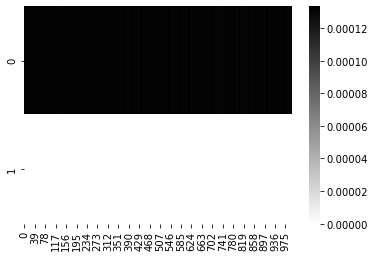

In [779]:

total_loss = 0
for g in eval_loader:
    net.eval()
    with torch.no_grad():
        m = g.ndata['mask'].bool()
        y = net(g)[-1][m]
        y_hat = g.ndata['y_hat'][m].float()
        
        x = torch.stack([y, y_hat]).squeeze(-1)
        sns.heatmap(x.detach().numpy(), cmap='binary')

#### TODO: maybe don't just use a mask, but use a different graph structure to predict?

What if, if a cause is present we add it to the graph and we choose a comletely random node and try to predict whether it should be on or off.

In [645]:
import random



class LungCancerDataset_OneTarget(Dataset):
    
    def __init__(self, df):
        self.df = df
        self.acquired = {}
        
    def __getitem__(self, i):
        row = df.iloc[i]
        local_causes = []
        for k, v in row.items():
            if v == 1:
                local_causes.append(k)

        target_outcomes = [random.choice(df.columns)]
        local_causes = sorted(list(set(local_causes).union(set(target_outcomes))))

        target_mask = torch.zeros(len(local_causes))
        for i, x in enumerate(local_causes):
            if x == target_outcome:
                target_mask[i] = 1

        g = dgl.graph(([], []))
        g.add_nodes(len(local_causes))
        g.ndata['x'] = torch.tensor([cause_to_idx[c] for c in local_causes]).unsqueeze(1)
        y = torch.tensor(row[target_outcomes].values).unsqueeze(0)
        y = y.expand(g.number_of_nodes(), -1)
        g.ndata['y'] = y
        g.ndata['target_mask'] = target_mask
        add_complete_edges(g)
        assert g.number_of_nodes()
        return g
    
    def __len__(self):
        return len(self.df)


In [666]:
class Network2(nn.Module):
    
    def __init__(self, d_model, h=16, n_heads=4, dropout=0.2):
        super().__init__()
        self.src_embedding = nn.Sequential(
            nn.Embedding(d_model, h),
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU()
        )
        self.dst_embedding = nn.Sequential(
            nn.Embedding(d_model, h),
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU()
        )
        self.embedding = nn.Sequential(
            nn.Embedding(d_model, h),
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, h),
            nn.LeakyReLU()
        )
        self.attn = AddNorm(h, layer=MultiHeadAttention(h, n_heads), dropout=dropout)
        self.core = nn.Sequential(
            nn.Linear(h, h),
            nn.LeakyReLU(),
        )
        self.decode = nn.Sequential(
            nn.Linear(h, h),
            nn.LeakyReLU(),
            nn.Linear(h, 1)
        )
            
        
    def forward(self, g, n_loops=5):
        with g.local_scope():
            g.ndata['a'] = self.src_embedding(g.ndata['x'].flatten().long())
            g.ndata['b'] = self.dst_embedding(g.ndata['x'].flatten().long())
            g.ndata['h'] = self.embedding(g.ndata['x'].flatten().long())
            out_arr = []

            for i in range(n_loops):
                g.ndata['h'] = self.attn(g.ndata['h'], args=(g, g.ndata['a'], g.ndata['b'], g.ndata['h']))
                g.ndata['h'] = self.core(g.ndata['h'])
                out = nn.Sigmoid()(self.decode(g.ndata['h']))
                out_arr.append(out[g.ndata['target_mask'].bool()])
            return torch.stack(out_arr)
        
net = Network2(32)


dataset = LungCancerDataset_OneTarget(df.iloc[:-100])
loader = DataLoader(dataset, batch_size=32, collate_fn=dgl.batch, shuffle=True)
for x in loader:
    ...
# set out to predict each node in the graph as apposed to just predicting lung cancer
# we are not making any assumptions that lung_cancer is the target which we seek to understand
# rather, we try to learn the entire causal graph
net(x).shape

torch.Size([5, 8, 1])

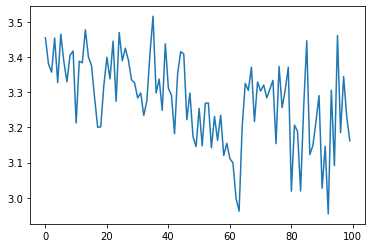

Exception ignored in: <function _releaseLock at 0x7f37ff325550>
Traceback (most recent call last):
  File "/home/justin/anaconda3/envs/openaigym/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 42684, 42696, 42708, 42709, 42721, 42733, 42745) exited unexpectedly

In [669]:
from tqdm.auto import tqdm
from IPython import display
from matplotlib import pylab as plt

net = Network2(d_model=len(df.columns), h=128, n_heads=8, dropout=0.2)

dataset = LungCancerDataset_OneTarget(df.iloc[:-1000])
loader = DataLoader(dataset, batch_size=256, collate_fn=dgl.batch, shuffle=True, num_workers=12)

eval_dataset = LungCancerDataset_OneTarget(df.iloc[-1000:])
eval_loader = DataLoader(dataset, batch_size=len(eval_dataset), collate_fn=dgl.batch, shuffle=False)

optim = torch.optim.AdamW(net.parameters(), lr=1e-3)
lossfn = torch.nn.BCELoss()
losses = []

def evaluate():
    total_loss = 0
    for g in eval_loader:
        net.eval()
        with torch.no_grad():
            y_arr = net(g)[-1:]
            y_hat = g.ndata['y'][g.ndata['target_mask'].bool()]
            loss = torch.tensor(0.)
            for y in y_arr:
                loss += lossfn(y, y_hat.float())
            
            total_loss+=loss.detach().item()
    return total_loss

eval_losses = []
for epoch in tqdm(range(1000)):
    for g in loader:
        y_arr = net(g)
        y_hat = g.ndata['y'][g.ndata['target_mask'].bool()]
        loss = torch.tensor(0.)
        for y in y_arr:
            loss += lossfn(y, y_hat.float())
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.detach().item())
        display.clear_output(wait=True)
        plt.plot(losses)
        plt.show()
        
#         display.clear_output(wait=True)
#         plt.plot(eval_losses)
#         plt.show()
        
    if epoch % 1 == 0:
        eval_loss = evaluate()
        eval_losses.append(eval_loss)
